# Transfer Learning on a network, where roads are clustered into classes

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
import dan_models
import dan_utils

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 把速度矩阵分类

In [4]:
randseed = 25
dan_utils.setup_seed(randseed)
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
id_402 = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)
part1 = pd.read_csv('../res/%i_res%i_det_partition_results1.csv'%(randseed, res))
part2 = pd.read_csv('../res/%i_res%i_det_partition_results2.csv'%(randseed, res))

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = id_402[id_402['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = id_402['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

There are 5 class(es)


## 制作 nearest_road_id.csv 和speed.csv

In [5]:
dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

## 以上做好了near_road矩阵，接下来做flow/speed矩阵

In [6]:
seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 30

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = dan_utils.get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp[:])
    v_class_temp = v_class_temp.loc[v_class_temp['id'].isin(det_list_class_temp[:])]
    v_class[i] = v_class_temp

C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Visulization

In [7]:
def plot_dets(det_list_class_i, if_save):
    
    for i in range(len(id_402)):
        det_id = id_402.loc[i, 'id']
        cls_402 = id_402.loc[i, 'class_i']
        try:
            cls_det = part1[part1['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part1.loc[part1['det'] == det_id, '0'] = cls_402
                print(i)
        except:
            cls_det = part2[part2['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part2.loc[part2['det'] == det_id, '0'] = cls_402
                print(i)
    
    
    fig = plt.figure(figsize=[40, 15], dpi=125)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(det_list_class_i)):
        det_id = det_list_class_i[i]
        x = id_402.loc[id_402['id']==det_id, 'lat']
        y = id_402.loc[id_402['id']==det_id, 'long']
#         ipdb.set_trace()
        if det_id in part1['det'].values:
            ax1.plot(x, y, marker='+', color='red', markersize=10, markerfacecolor='none')
            ax1.text(x-0.005, y, det_id, rotation=45)
        elif det_id in part2['det'].values:
            ax2.plot(x, y, marker='o', color='red', markersize=10, markerfacecolor='none')
            ax2.text(x-0.005, y, det_id, rotation=45)
            
    plt.show()
    if if_save:
        fig.savefig('../network_classification/img/%i_res%i_class_%i.png'%(randseed, res, class_i_))
        print(1)
    plt.close()
    
    return

10
137
138
139
140
142
170
212
341
342
343
344
345
346


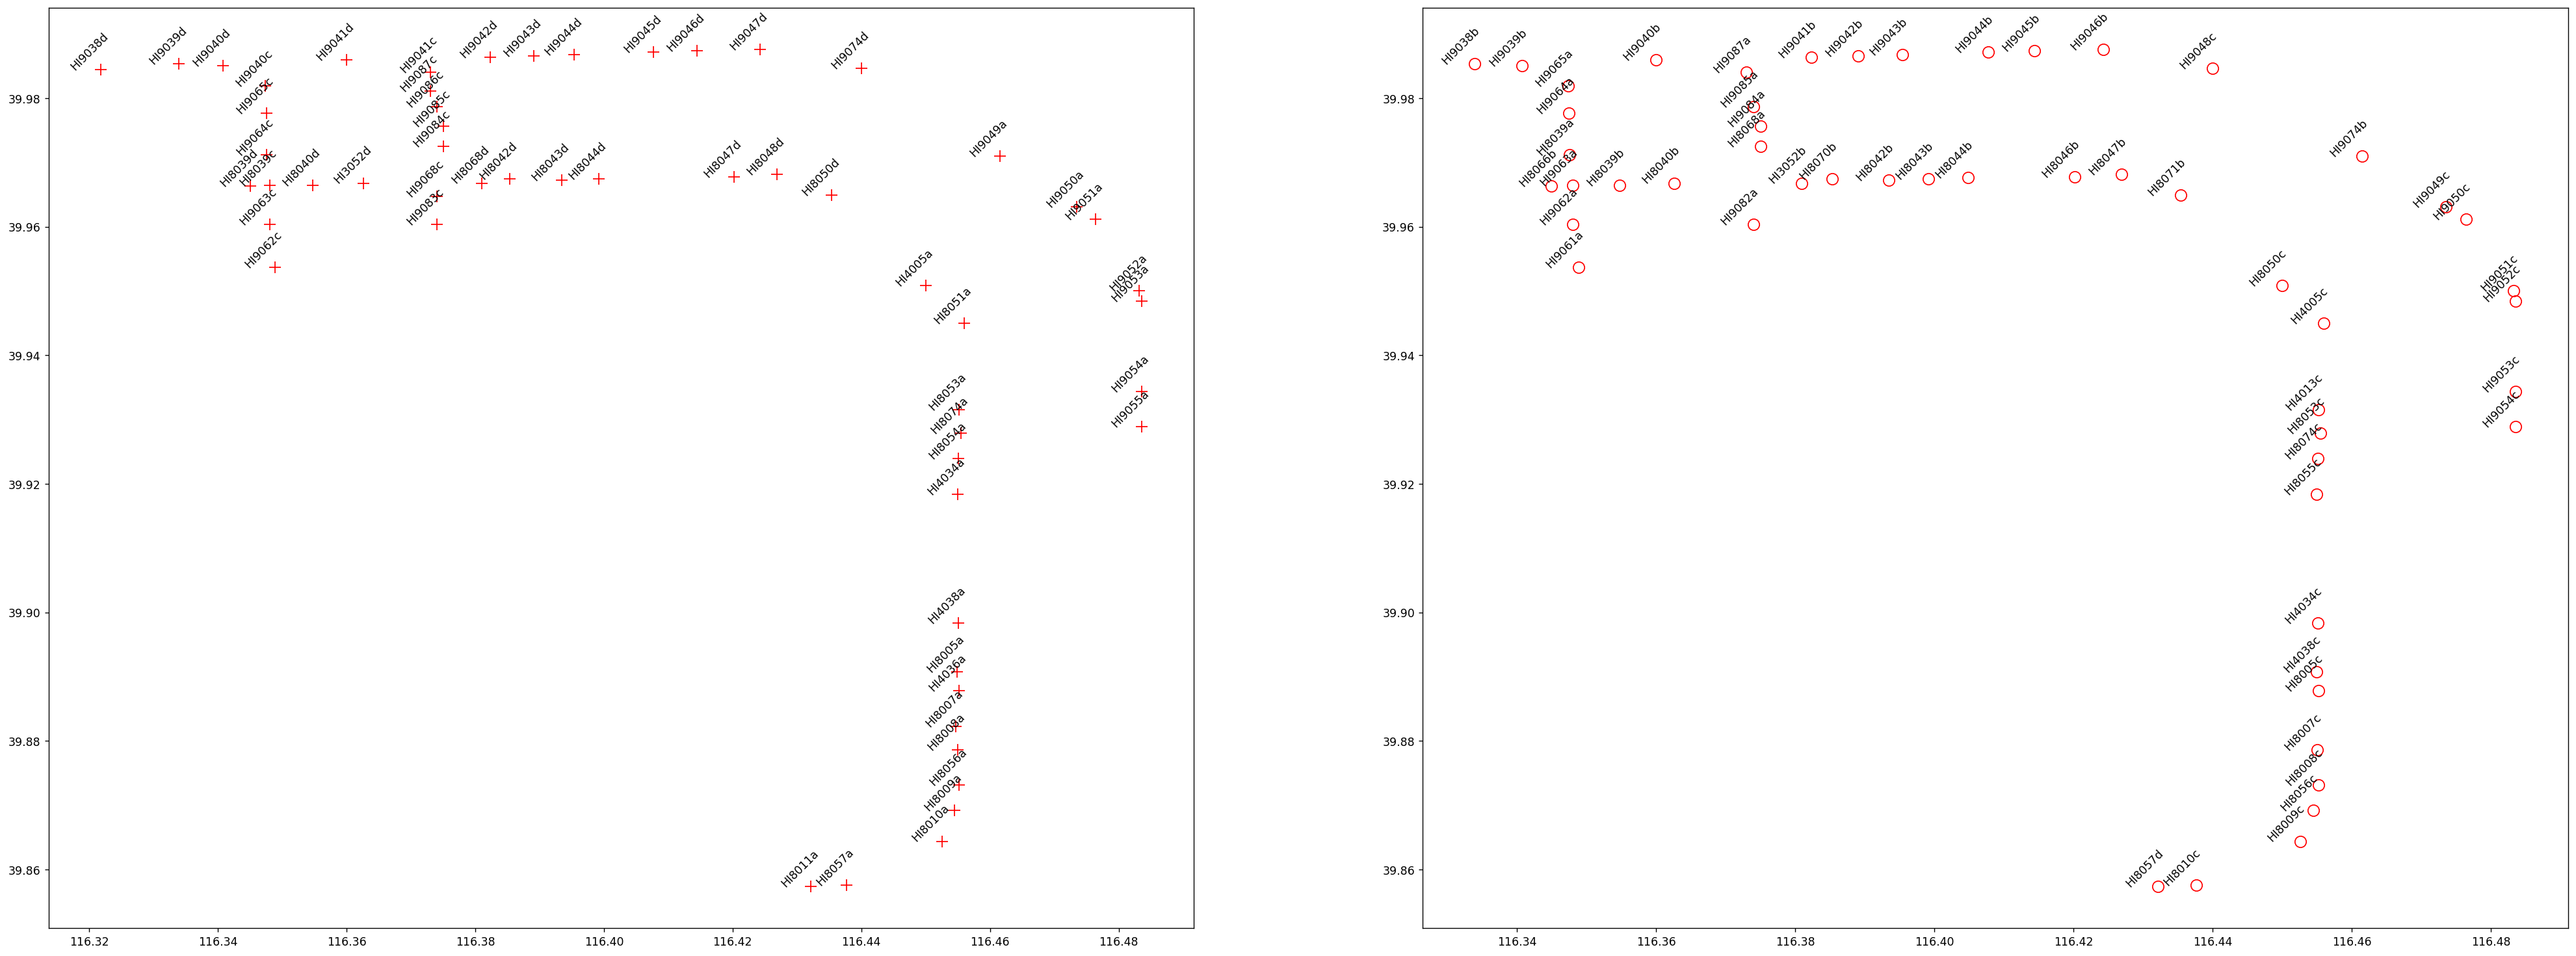

In [8]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i_ = 4
plot_dets(det_list_class[class_i_], if_save=0)

### Select detectors manually, then assemble v_class matrix

In [9]:
selected_dets = pd.read_csv('../network_classification/selected_dets.csv', index_col=0)

In [10]:
# filt, so that only selected dets remain
class_set = [2, 3, 4]
for i in range(len(class_set)):
    cls_ = class_set[i]
    det_set = selected_dets.loc[selected_dets['class']==cls_, 'det'].values
    v_class[cls_] = v_class[cls_].loc[v_class[cls_]['id'].isin(det_set)]

In [11]:
# make near_road matrix
near_road_set = []
for i in range(num_class):
    det_set = v_class[i]['id'].values
#     ipdb.set_trace()
    near_road_set.append(dan_utils.rds_mat(dist_mat, det_set, seg))

## Evaluation of 2 datasets

In [12]:
def get_NSk(set1, set2):
    # designated for v_class1 and 2
    set1_v_mean = set1.iloc[:, 2:-1].T.mean().T
    set2_v_mean = set2.iloc[:, 2:-1].T.mean().T
    
    var1 = set1_v_mean.std()**2
    var2 = set2_v_mean.std()**2
    
    u1 = set1_v_mean.mean()
    u2 = set2_v_mean.mean()
    
    return 2*var1 / (var1 + var2 + (u1 - u2)**2)

In [13]:
NSk_set = np.array([])

for i in class_set:
    for j in class_set:
        if i!=j:
            NSk = get_NSk(v_class[i], v_class[j])
            NSk_set = np.append(NSk_set, NSk)

print(NSk_set.mean())

0.9485695189621944


# 源代码如下 （训练）
# Input classes here

In [14]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 3
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 4
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

k, t_p, t_input, t_pre, num_links = 5, 10, 12, 3, 25

In [15]:
near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 20
to_day = 30

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, 
    k, t_p, t_input, t_pre, num_links
)

(25, 1584)
(1161, 5, 12, 25)
(1161, 5, 12, 25)
(0, 5, 12, 25)
(1161, 25, 3)
(0, 25, 3)


In [16]:
near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 0.3

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, 
    k, t_p, t_input, t_pre, num_links
)

(25, 1584)
(1161, 5, 12, 25)
(348, 5, 12, 25)
(813, 5, 12, 25)
(348, 25, 3)
(813, 25, 3)


In [17]:
#模型构建
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 25)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 12, 25)    100         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 12, 25)    5650        batch_normalization[0][0]        
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 5, 12, 25)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [18]:
#参数加载
finish_model.load_weights('../model/source_%s.h5'%class_color_set[class_src])
#模型预测
model_pre = finish_model.predict([image_test_target, day_test_target])

In [19]:
model_pre.shape

(813, 25, 3)

In [20]:
#预测结果存储
dan_utils.save_np(model_pre.reshape(model_pre.shape[0], -1), '../model/middle_res/%i_res%i_modelpre_%s_%s.csv'%(randseed, res, class_color_set[class_src], class_color_set[class_tar]))

In [21]:
#transfer without FT 预测精度计算
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target)

print('mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

mape = 0.2933885003264367
smape = 0.3216851362216183
mae = 15.839614989475345


In [22]:
# from sklearn import metrics
def mmd (x, y):
    return np.abs(x.mean() - y.mean())

In [23]:
import scipy.stats
def norm_data(data):
    min_ = min(data)
    max_ = max(data)
    normalized_data = data - min_ / (max_ - min_)
    return normalized_data
    
def js_divergence(set1, set2):
    p = np.array(set1.iloc[:, 2:-1].T.mean().T)
    q = np.array(set2.iloc[:, 2:-1].T.mean().T)
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)
    # return scipy.stats.entropy(p, q)  # kl divergence

In [24]:
middle1 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_1').output)
middle2 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_2').output)

middle_result_source1 = middle1.predict([image_train_source, day_train_source])
middle_result_target1 = middle1.predict([image_train_target, day_train_target])

middle_result_source2 = middle2.predict([image_train_source, day_train_source])
middle_result_target2 = middle2.predict([image_train_target, day_train_target])

# save intermidiate results
dan_utils.save_np(middle_result_source1, '../model/middle_res/%i_res%i_middle_result_source1_%s_%s.csv'\
                 %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
dan_utils.save_np(middle_result_target1, '../model/middle_res/%i_res%i_middle_result_target1_%s_%s.csv'\
                 %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
dan_utils.save_np(middle_result_source2, '../model/middle_res/%i_res%i_middle_result_source2_%s_%s.csv'\
                 %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
dan_utils.save_np(middle_result_target2, '../model/middle_res/%i_res%i_middle_result_target2_%s_%s.csv'\
                 %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))


lamb = js_divergence(v_class1.iloc[:, 2:-1], v_class2.iloc[:, 2:-1])
lamb = 0

def new_loss(output_final, label_train_target):
    loss1 = K.mean(K.square(output_final - label_train_target), axis=-1) 
    loss2 = lamb * ( mmd(middle_result_source1, middle_result_target1) + mmd(middle_result_source2, middle_result_target2) )
#     loss2 = 0.001 * mmd(middle_result_source2, middle_result_target2)
#     print('Lambda is %.4f'%lamb)
    overall_loss = loss1 + loss2
    
    return overall_loss

In [25]:
finish_model.compile(optimizer='adam', loss=new_loss)

In [26]:
finish_model.fit([image_train_target, day_train_target], label_train_target, epochs=300, batch_size=462,
validation_data=([image_test_target,day_test_target], label_test_target))

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 634.1784 - val_loss: 418.7579
Epoch 2/300
1/1 [==============================] - 0s 43ms/step - loss: 554.8432 - val_loss: 459.9806
Epoch 3/300
1/1 [==============================] - 0s 41ms/step - loss: 485.2231 - val_loss: 509.2465
Epoch 4/300
1/1 [==============================] - 0s 40ms/step - loss: 437.7458 - val_loss: 562.0995
Epoch 5/300
1/1 [==============================] - 0s 39ms/step - loss: 401.1774 - val_loss: 610.5290
Epoch 6/300
1/1 [==============================] - 0s 43ms/step - loss: 382.2675 - val_loss: 647.3534
Epoch 7/300
1/1 [==============================] - 0s 40ms/step - loss: 356.9908 - val_loss: 669.5024
Epoch 8/300
1/1 [==============================] - 0s 41ms/step - loss: 340.8825 - val_loss: 677.4585
Epoch 9/300
1/1 [==============================] - 0s 42ms/step - loss: 324.6951 - val_loss: 674.0731
Epoch 10/300
1/1 [==============================] - 0s 40ms/step - loss: 311.3574 - 

1/1 [==============================] - 0s 40ms/step - loss: 170.8989 - val_loss: 290.6224
Epoch 81/300
1/1 [==============================] - 0s 46ms/step - loss: 170.4485 - val_loss: 288.0931
Epoch 82/300
1/1 [==============================] - 0s 45ms/step - loss: 170.0867 - val_loss: 285.6467
Epoch 83/300
1/1 [==============================] - 0s 42ms/step - loss: 168.4279 - val_loss: 283.4067
Epoch 84/300
1/1 [==============================] - 0s 46ms/step - loss: 168.9563 - val_loss: 280.9976
Epoch 85/300
1/1 [==============================] - 0s 46ms/step - loss: 168.0362 - val_loss: 278.5208
Epoch 86/300
1/1 [==============================] - 0s 40ms/step - loss: 167.4708 - val_loss: 276.0838
Epoch 87/300
1/1 [==============================] - 0s 39ms/step - loss: 166.7697 - val_loss: 273.6568
Epoch 88/300
1/1 [==============================] - 0s 38ms/step - loss: 166.2886 - val_loss: 271.4573
Epoch 89/300
1/1 [==============================] - 0s 45ms/step - loss: 164.7976 - va

1/1 [==============================] - 0s 38ms/step - loss: 124.6086 - val_loss: 187.6393
Epoch 160/300
1/1 [==============================] - 0s 40ms/step - loss: 123.3249 - val_loss: 187.6343
Epoch 161/300
1/1 [==============================] - 0s 45ms/step - loss: 122.8062 - val_loss: 187.1208
Epoch 162/300
1/1 [==============================] - 0s 39ms/step - loss: 122.7995 - val_loss: 186.1741
Epoch 163/300
1/1 [==============================] - 0s 40ms/step - loss: 121.8942 - val_loss: 184.9493
Epoch 164/300
1/1 [==============================] - 0s 45ms/step - loss: 121.1221 - val_loss: 183.7529
Epoch 165/300
1/1 [==============================] - 0s 39ms/step - loss: 120.8952 - val_loss: 182.4613
Epoch 166/300
1/1 [==============================] - 0s 40ms/step - loss: 120.6650 - val_loss: 181.5301
Epoch 167/300
1/1 [==============================] - 0s 37ms/step - loss: 119.6206 - val_loss: 180.7452
Epoch 168/300
1/1 [==============================] - 0s 38ms/step - loss: 118.

1/1 [==============================] - 0s 39ms/step - loss: 94.7796 - val_loss: 152.4861
Epoch 239/300
1/1 [==============================] - 0s 39ms/step - loss: 94.6459 - val_loss: 152.0823
Epoch 240/300
1/1 [==============================] - 0s 39ms/step - loss: 94.3440 - val_loss: 151.5621
Epoch 241/300
1/1 [==============================] - 0s 39ms/step - loss: 93.9160 - val_loss: 151.2042
Epoch 242/300
1/1 [==============================] - 0s 38ms/step - loss: 93.6285 - val_loss: 150.8151
Epoch 243/300
1/1 [==============================] - 0s 39ms/step - loss: 92.6626 - val_loss: 150.2775
Epoch 244/300
1/1 [==============================] - 0s 38ms/step - loss: 93.0656 - val_loss: 149.8548
Epoch 245/300
1/1 [==============================] - 0s 38ms/step - loss: 92.4973 - val_loss: 149.4837
Epoch 246/300
1/1 [==============================] - 0s 45ms/step - loss: 92.3888 - val_loss: 149.2632
Epoch 247/300
1/1 [==============================] - 0s 45ms/step - loss: 92.3117 - val

In [27]:
model_pre = finish_model.predict([image_test_target, day_test_target])

In [28]:
#模型保存
finish_model.save_weights('../model/transfer_DAN_%s_%s_mape=%.5f.h5'%(class_color_set[class_src], class_color_set[class_tar], dan_utils.mape_loss_func(model_pre, label_test_target)))

In [29]:
#transfer with DAN 预测精度计算

mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target)

print('mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

mape = 0.1762137579130856
smape = 0.17120206829027573
mae = 8.7837323793637


In [30]:
mape_list = []
for i in range(num_links):
    a1 = dan_utils.mape_loss_func(model_pre[:,i,:], label_test_target[:,i,:])
    mape_list.append(a1)

mape_pd = pd.Series(mape_list)
mape_pd.sort_values()

20    0.086813
13    0.093751
12    0.099206
18    0.100881
21    0.102134
16    0.113669
23    0.118857
0     0.143544
2     0.145889
8     0.148389
24    0.151525
7     0.153901
3     0.155331
15    0.155951
10    0.171041
6     0.173819
5     0.175967
9     0.182368
1     0.237529
22    0.251943
11    0.253367
19    0.267123
17    0.284034
4     0.306098
14    0.332213
dtype: float64

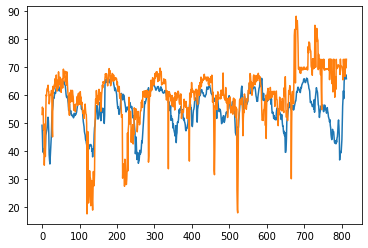

In [31]:
import matplotlib.pyplot as plt

plt.plot(model_pre[:, 0, 0])
plt.plot(label_test_target[:, 0, 0])

C:\Users\10169\AppData\Local\Temp/ipykernel_17008/2580775615.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


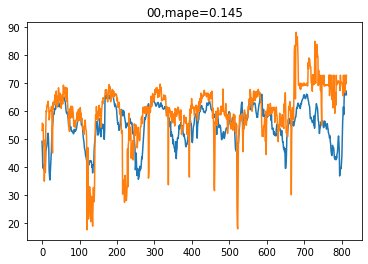

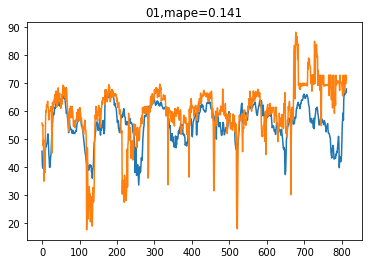

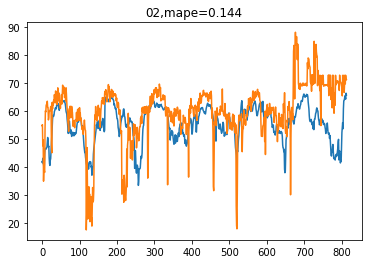

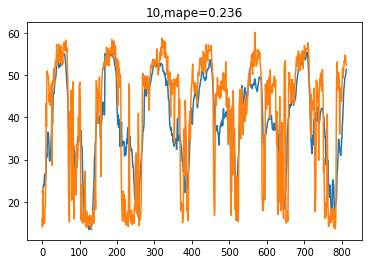

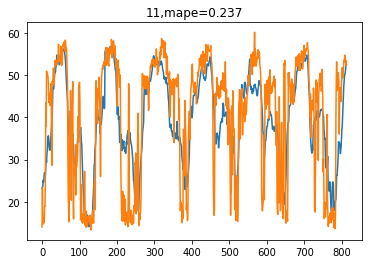

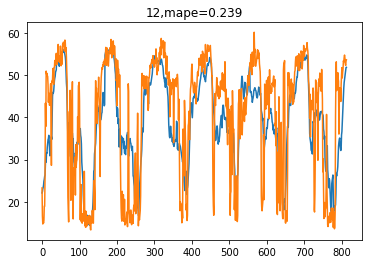

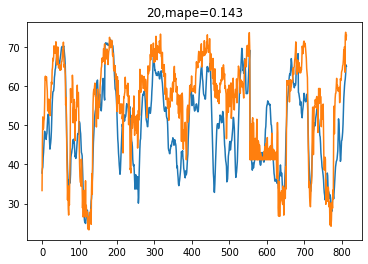

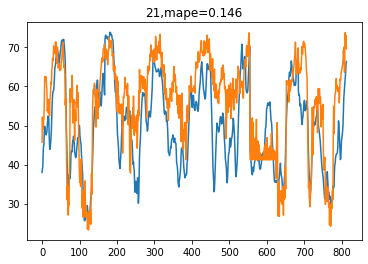

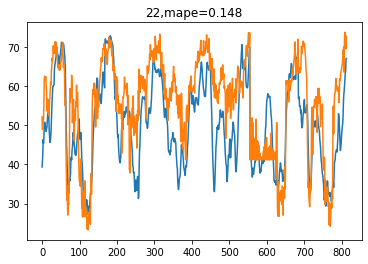

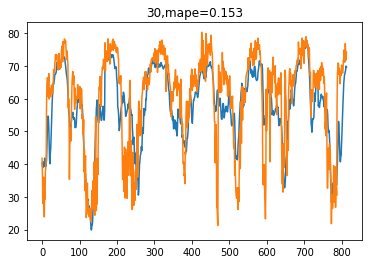

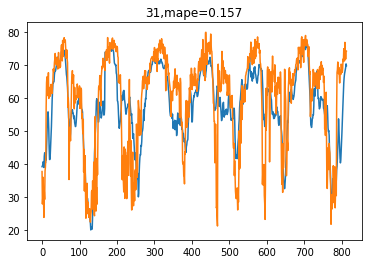

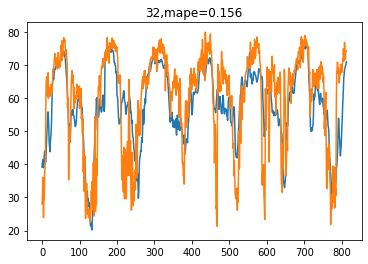

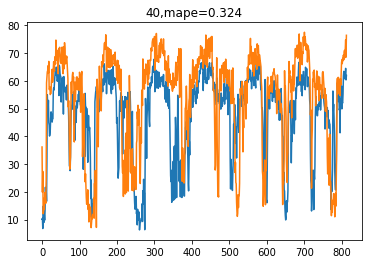

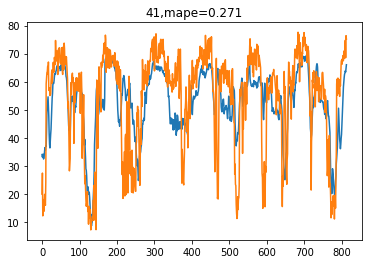

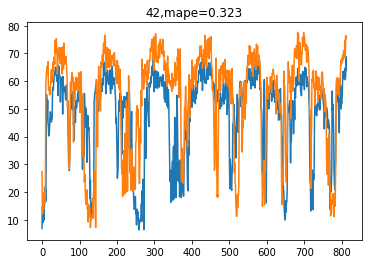

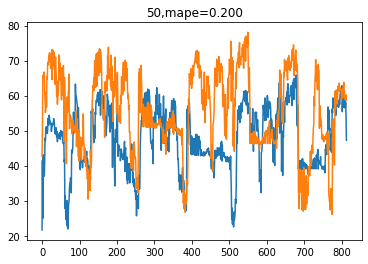

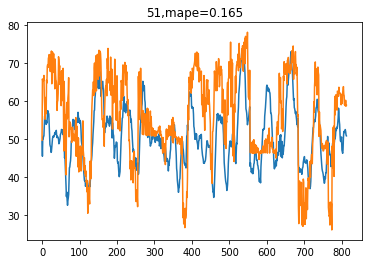

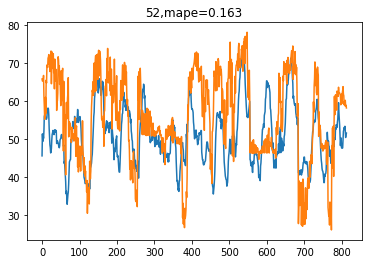

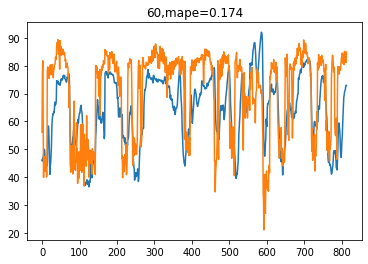

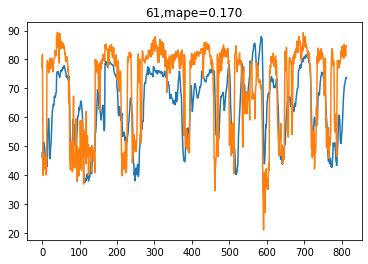

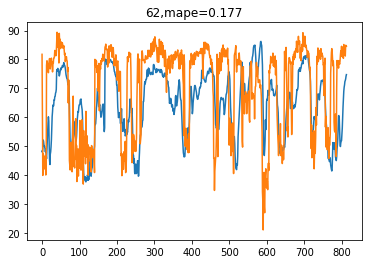

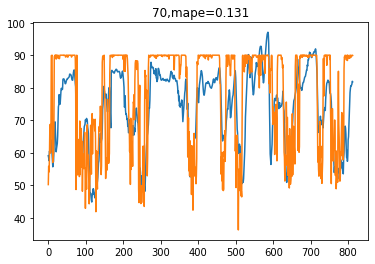

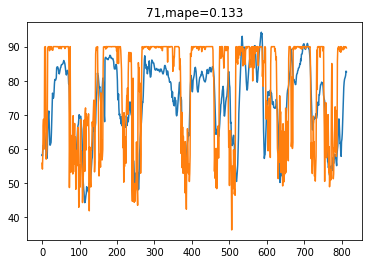

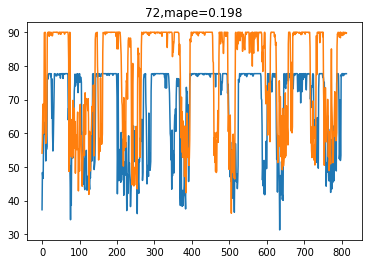

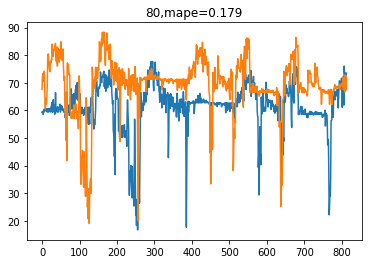

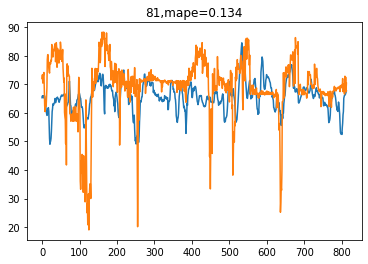

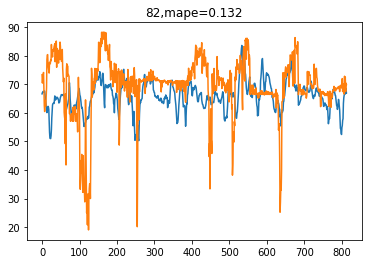

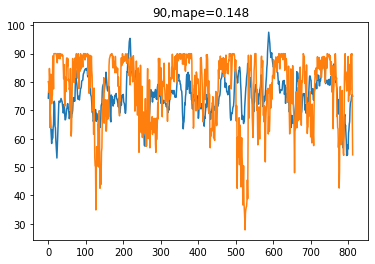

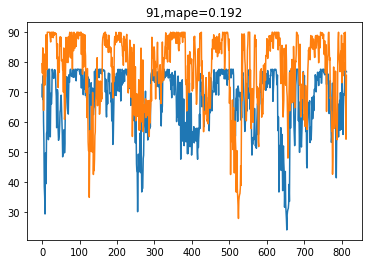

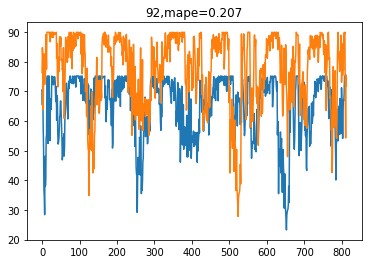

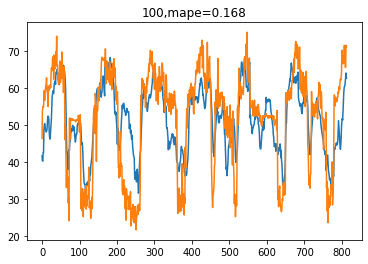

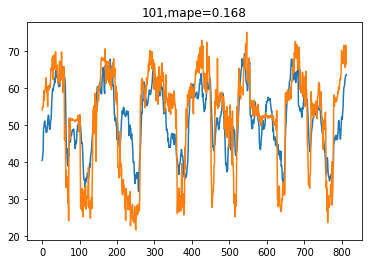

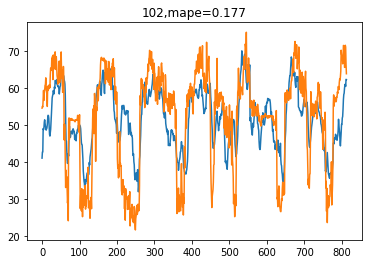

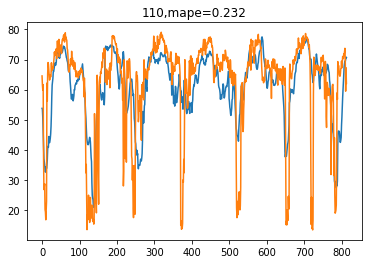

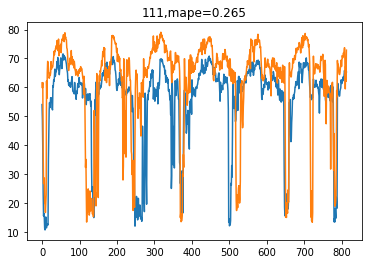

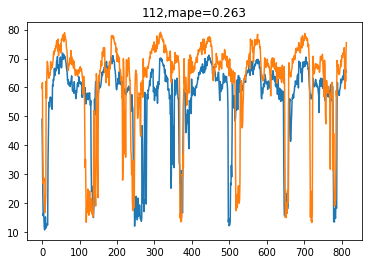

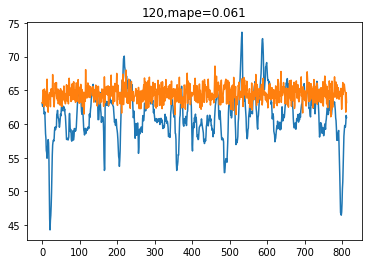

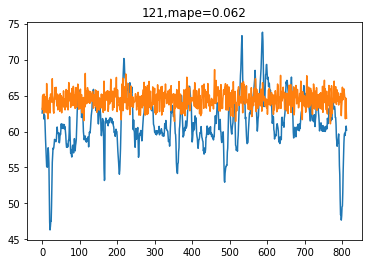

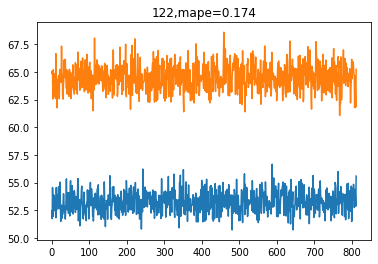

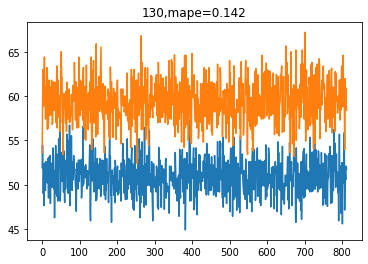

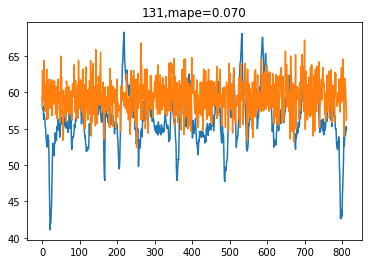

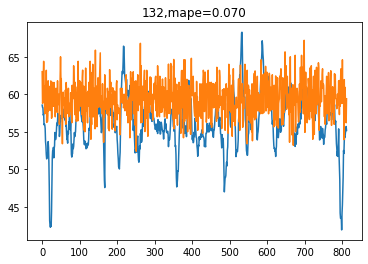

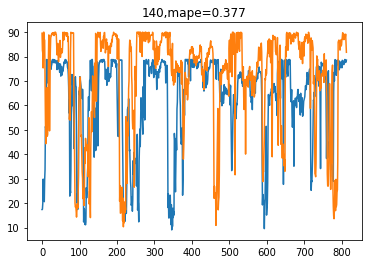

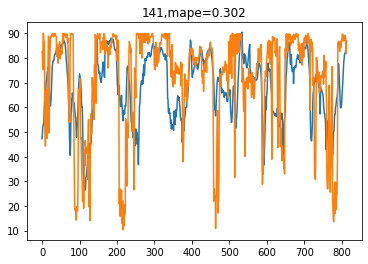

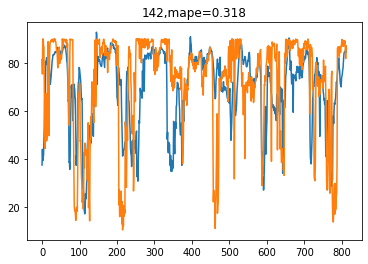

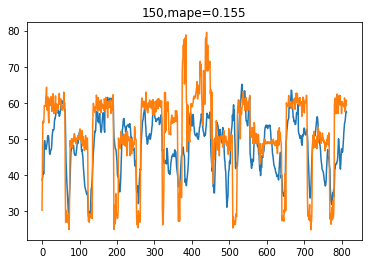

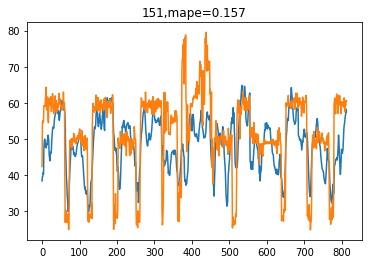

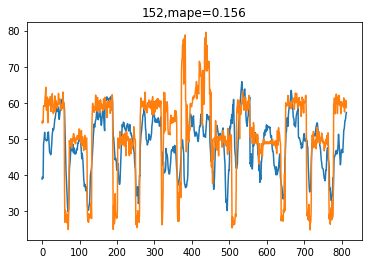

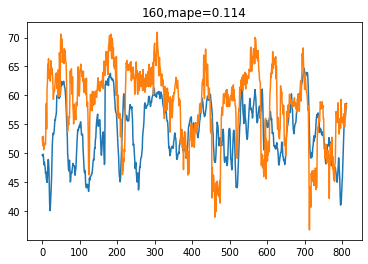

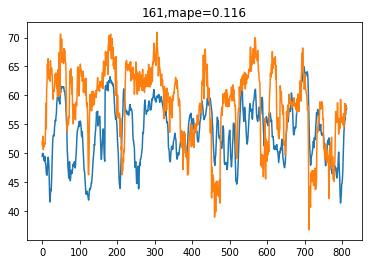

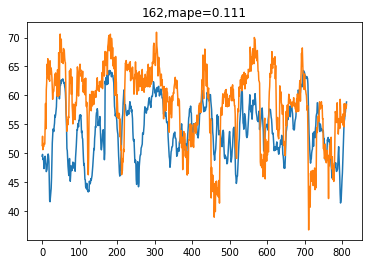

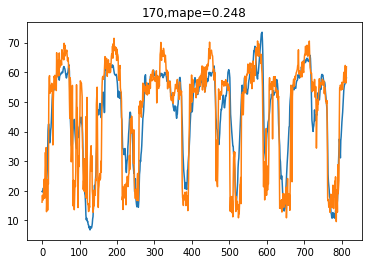

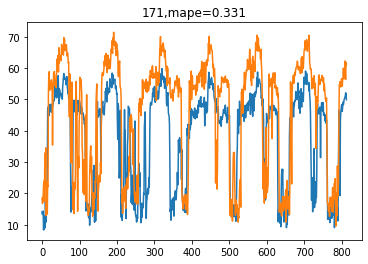

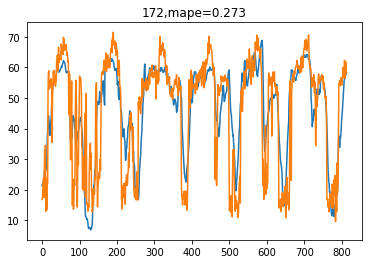

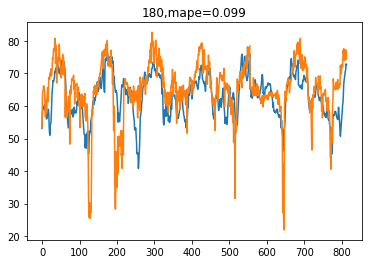

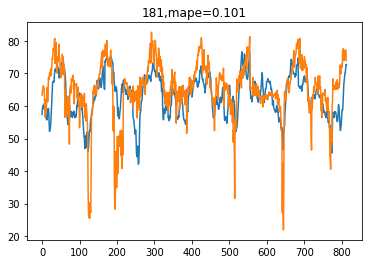

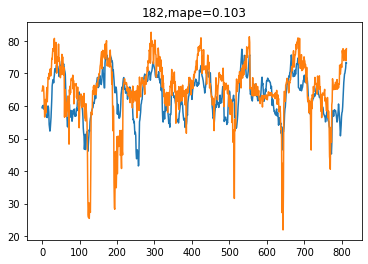

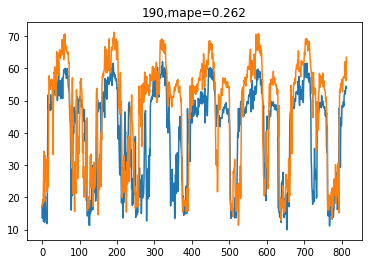

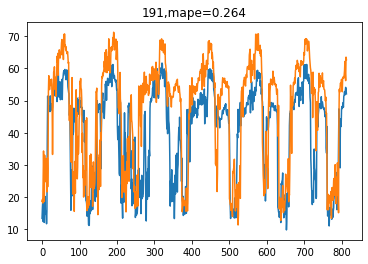

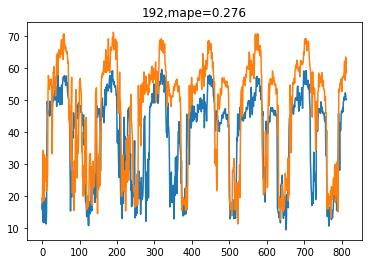

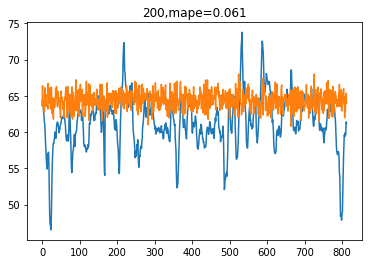

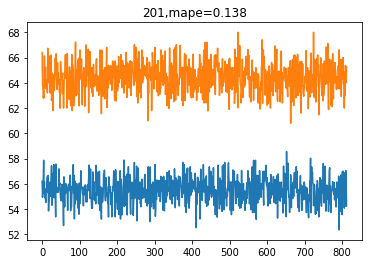

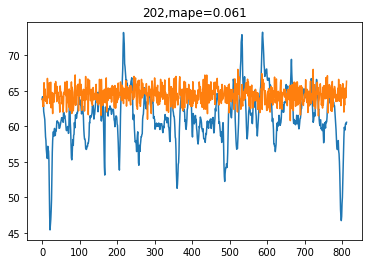

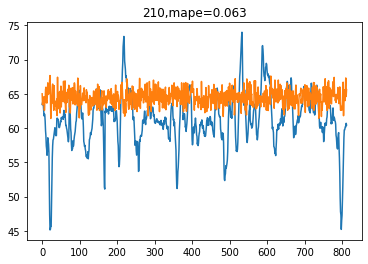

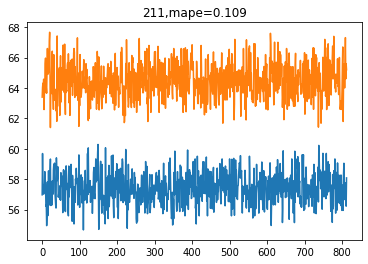

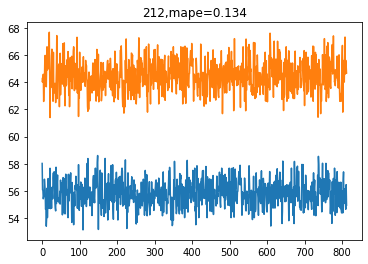

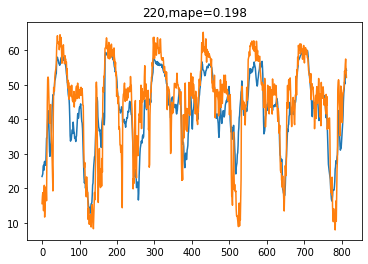

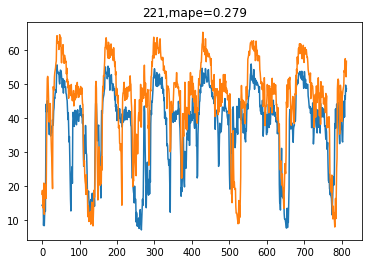

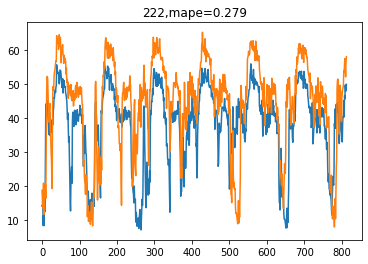

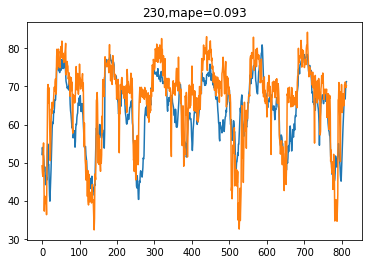

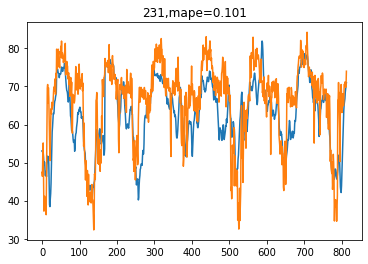

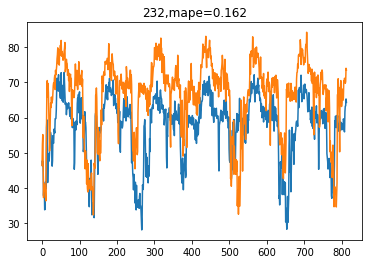

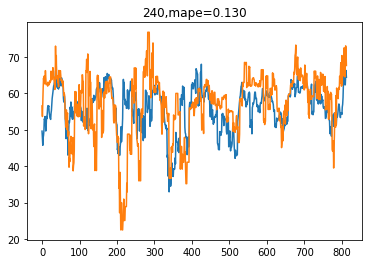

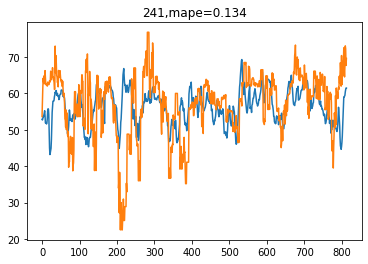

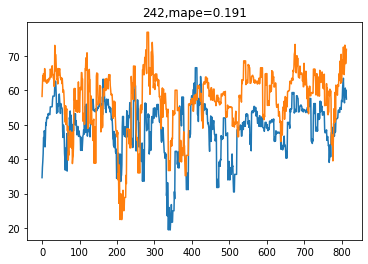

In [32]:
mape_set = []
for i in range(25):
    for j in range(3):
        plt.figure()
        plt.plot(model_pre[:, i, j])
        plt.plot(label_test_target[:, i, j])
        mape = dan_utils.mape_loss_func(model_pre[:, i, j], label_test_target[:, i, j])
        mape_set.append(mape)
        plt.title('%i%i,mape=%.3f'%(i, j, mape))